<a href="https://colab.research.google.com/github/ai-fast-track/icevision/blob/classification/notebooks/classification_timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
# !pip install icevision[all] -u -q
!pip install git+git://github.com/airctic/icevision.git#egg=icevision[all] --upgrade -q

In [ ]:
!pip install timm -q

In [3]:
from icevision.all import *
import timm

ModuleNotFoundError: No module named 'mmcv._ext'

In [ ]:
data_dir = fastai.untar_data(fastai.URLs.PETS)

In [ ]:
data_dir.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [ ]:
get_image_files(data_dir/'images')

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_103.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_104.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_105.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_106.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_107.jpg')...]

In [ ]:
class PetsParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin):
    def __init__(self, data_dir):
        super().__init__()
        self.data_dir = Path(data_dir/'images')
        self.img_filepaths = get_image_files(self.data_dir)
        
    def __iter__(self) -> Any:
        yield from self.img_filepaths
        
    def __len__(self) -> int:
        return len(self.img_filepaths)
        
    def imageid(self, o) -> Hashable:
        return o.stem
    
    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))
    
    def filepath(self, o) -> Union[str, Path]:
        return o
    
    def label_from_filepath(self, o):
        return o.stem.split('_')[0]

    def labels(self, o) -> List[int]: 
        label_name = self.label_from_filepath(o)
        return [label_name]

In [ ]:
parser = PetsParser(data_dir)

In [ ]:
train_records, valid_records = parser.parse(autofix=False)

  0%|          | 0/7390 [00:00<?, ?it/s]

In [ ]:
parser.class_map

<ClassMap: {'background': 0, 'Abyssinian': 1, 'Bengal': 2, 'Birman': 3, 'Bombay': 4, 'British': 5, 'Egyptian': 6, 'Maine': 7, 'Persian': 8, 'Ragdoll': 9, 'Russian': 10, 'Siamese': 11, 'Sphynx': 12, 'american': 13, 'basset': 14, 'beagle': 15, 'boxer': 16, 'chihuahua': 17, 'english': 18, 'german': 19, 'great': 20, 'havanese': 21, 'japanese': 22, 'keeshond': 23, 'leonberger': 24, 'miniature': 25, 'newfoundland': 26, 'pomeranian': 27, 'pug': 28, 'saint': 29, 'samoyed': 30, 'scottish': 31, 'shiba': 32, 'staffordshire': 33, 'wheaten': 34, 'yorkshire': 35}>

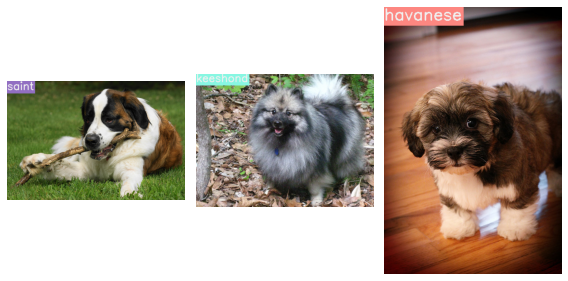

In [ ]:
show_records(train_records[:3], ncols=3, class_map=parser.class_map, figsize=(8, 6))

In [ ]:
size = 224
presize = 352
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

In [ ]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

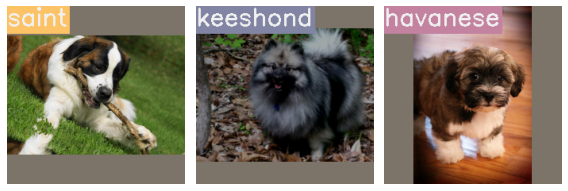

In [ ]:
samples = [train_ds[i] for i in range(3)]
show_samples(samples, ncols=3, figsize=(8, 6), class_map=parser.class_map)

## Dataloader

In [ ]:
# def build_train_batch(samples, batch_tfms):
#     samples = common_build_batch(records=samples, batch_tfms=batch_tfms)
    
#     images, labels = [], []
#     for sample in samples:
#         images.append(im2tensor(sample['img']))
#         labels.extend(sample['labels'])

#     xb = torch.stack(images)
#     yb = tensor(labels)
    
#     return xb, yb

In [ ]:
# def build_valid_batch(samples, batch_tfms):
#     samples = common_build_batch(records=samples, batch_tfms=batch_tfms)
    
#     images = [im2tensor(sample['img']) for sample in samples]
#     return (torch.stack(images),)

In [ ]:
# train_dl = transform_dl(train_ds, build_train_batch, batch_size=64, num_workers=6, shuffle=True)
# valid_dl = transform_dl(valid_ds, build_train_batch, batch_size=64, num_workers=6, shuffle=False)

In [ ]:
train_dl = timm.train_dl(train_ds, batch_size=16, num_workers=0, shuffle=True)
valid_dl = timm.valid_dl(valid_ds, batch_size=16, num_workers=0, shuffle=False)

In [ ]:
batch = next(iter(train_dl))

## Fastai training

In [ ]:
fast_train_dl = engines.fastai.convert_dataloader_to_fastai(train_dl)
fast_valid_dl = engines.fastai.convert_dataloader_to_fastai(valid_dl)

fast_dls = fastai.DataLoaders(fast_train_dl, fast_valid_dl)

In [ ]:
device = fastai.default_device()

In [ ]:
fast_dls = fast_dls.to(device)

In [ ]:
from pprint import pprint
model_names = timm.list_models(pretrained=True)
print('Number of models: ', len(model_names))
pprint(model_names)

Number of models:  271
['adv_inception_v3',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn107',
 'dpn131',
 'ecaresnet50d',
 'ecaresnet50d_pruned',
 'ecaresnet101d',
 'ecaresnet101d_pruned',
 'ecaresnetlight',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_lite0',
 'ens_adv_inception_resnet_v2',
 'ese_vovnet19b_dw',
 'ese_vovnet39b',
 'fbnetc_100',
 'gluon_inception_v3',
 'gluon_resnet18_v1b',
 'gluon_resnet34_v1b',
 'gluon_resnet50_v1b',
 'gluon_resnet50_v1c',
 'gluon_resnet50_v1d',
 'gluon_resn

In [ ]:
model = timm.create_model('resnet18', pretrained=True, num_classes=len(parser.class_map))


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet50_ram-a26f946b.pth" to /root/.cache/torch/hub/checkpoints/resnet50_ram-a26f946b.pth


In [1]:
loss_func = fastai.CrossEntropyLossFlat()
metrics = [fastai.accuracy]

learner = efficientdet.fastai.learner(dls=[train_dl, valid_dl], model=model, normalize=False, loss_func=loss_func, metrics=metrics)

#learner = fastai.Learner(fast_dls, model, normalize=False, loss_func=loss_func, metrics=metrics)
# learner = fastai.cnn_learner(fast_dls, fastai.resnet18, n_out=len(class_map), normalize=False, loss_func=loss_func, metrics=metrics)


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


NameError: name 'fastai' is not defined

In [ ]:
learner.lr_find()

In [ ]:
learner.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.584297,3.947649,0.255074,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.715935,0.901290,0.723951,00:33
1,0.705465,1.181235,0.625846,00:32
2,0.509727,0.500705,0.832206,00:32
3,0.309197,0.324967,0.892422,00:33
4,0.182386,0.269469,0.909337,00:32
